<a href="https://colab.research.google.com/github/ribka-5/AI/blob/main/RBL_Swarm_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KELOMPOK 8:
- Ribka Gabriela Siburian 120450108 (Ketua Kelompok)
- Adelia Mutiara Zulna 120450104 (Anggota)
- Cornel Silaen 120450102 (Anggota)
- Hafizul Damar Laya 120450028 (Anggota)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_rbl_.csv to data_rbl_.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data_rbl_.csv')
df

,No,Jenis Produk,Profit,Weight
0,1,Pipa PVC SNI DENYA S12.5 2inch,340,1377.000
1,2,Pipa PVC SNI DENYA S12.5 2inch,250,1012.500
2,3,Pipa PVC SNI DENYA S12.5 2inch,200,810.000
3,4,Pipa PVC SNI DENYA S12.5 3/4inch,2000,1480.000
4,5,Pipa PVC SNI DENYA S12.5 1inch,510,589.050
5,6,Pipa PVC SNI DENYA S12.5 1inch,300,346.500
6,7,Pipa PVC SNI DENYA S12.5 4inch,170,2081.650
7,8,Pipa PVC SNI DENYA S12.5 4inch,150,1836.750
8,9,Pipa PVC SNI DENYA S12.5 4inch,150,1836.750
9,10,Pipa PVC SNI DENYA S12.5 8inch,180,7465.500


In [ ]:
gen_individu = lambda n_individu,n_barang,a,b: np.random.uniform(a,b,(n_individu,n_barang))

def f_constrain(X,df,lim):
  return np.sum( X* df['Weight'].values ) <= lim

def f_profit(X,df):
  return np.sum(X * df['Profit'].values)

def f_obj(X,df,lim):
  return f_profit(X,df) if f_constrain(X,df,lim) else 0

def diskritisasi(bees):
  return np.round( 1/ ( 1 + np.exp(-1 * bees) ) )

def calculate_fitness(bees,df,p):
  d_bees = diskritisasi(bees)
  fitness = np.array( list(map( lambda x:f_obj(x,df,p['lim']) , d_bees )) )
  fitness = fitness.reshape( (-1,1) )
  return fitness

def sort_individu(fitness):
  return np.argsort(fitness)[::-1] #bees_with_f[bees_with_f[:,-1].argsort()[::-1]]

def solusi(bees_w_f):
  df_barang = pd.DataFrame(diskritisasi(bees_w_f[:,:-1]))
  cols = [ 'Jenis Produk ' + str(i+1) for i in range( df_barang.shape[1]) ]
  df_barang.columns = cols
  df_barang['Profit'] = bees_w_f[:,-1].reshape(-1,1)
  return df_barang


def generate_tipe_bee(presentase,bees):
  proporsi = np.array(presentase) * bees.shape[0]
  proporsi[-1] = bees.shape[0] - ( np.sum(proporsi) - proporsi[-1] )
  return np.concatenate( [ np.repeat( i , round(p) ) for i,p in enumerate(proporsi) ] )

def scout_movement(scout,a,b):
  return scout + np.random.uniform(a,b,size=scout.shape)

def employed_movement(employed,alpha):
  return employed + np.random.uniform(0,1,size=employed.shape) * alpha

def waggle_dance(bees,tipe,fitness):
  df = pd.DataFrame( np.concatenate( (bees,tipe.reshape((-1,1)),fitness),axis=1 ) )
  employed = df[ df.iloc[:,-2] == 0 ]
  p = employed.iloc[:,-1]
  if p.sum() == 0:
    p = p + 1
  return employed.sample(n=1,weights=p).iloc[:,:-2].values

def onlooker_movement(onlooker,beta,bees,tipe,fitness):
  term1 = np.random.uniform() * ( onlooker - waggle_dance(bees,tipe,fitness) )
  term2 = beta * np.random.uniform(size=onlooker.shape)
  return onlooker + term1 + term2

def get_bee_by_type(df,x):
  return df[df[df.columns[-2]] == x].iloc[:,:-2].values

def movement(bees,tipe,fitness,params):
  df = pd.DataFrame(np.concatenate((bees,tipe.reshape((-1,1)),fitness),axis=1))
  employed = employed_movement( get_bee_by_type(df,0), params['alpha'])
  onlooker = onlooker_movement( get_bee_by_type(df,1),params['beta'],bees,tipe,fitness )
  scouts = scout_movement( get_bee_by_type(df,2),params['a'] , params['b'] )
  new_bee = np.concatenate( (employed,onlooker,scouts) )
  return new_bee

def seleksi(bees,tipe,fitness,params):
  idxs = sort_individu(fitness.flatten())
  return bees[idxs] , tipe , fitness[idxs]

def inisialisasi(params,df):
  return gen_individu(int(params['n_individu']),int(params['n_barang']),params['a'],params['b'])

def ABC(params,df):
  generasi = 0
  bees = inisialisasi(params,df)
  tipe = generate_tipe_bee(params['presentase'],bees)
  fitness = calculate_fitness(bees,df,params)
  temp = []
  temp2 = []
  while generasi<params['max_generasi']:
    bees = movement(bees,tipe,fitness,params)
    fitness = calculate_fitness(bees,df,params)
    bees , tipe , fitness = seleksi(bees,tipe,fitness,params)
    generasi = generasi+1
    temp.append(fitness[0])
  return solusi(np.concatenate((bees,fitness),axis=1)), pd.DataFrame(temp)

def run_BCO(dfparams,df):
  Liest = []
  for i in range(dfparams.shape[0]):
    dfparmet = dfparams.loc[i].to_dict()
    dfparmet['presentase'] = dfparmet['presentase'].split('|')
    for j in range(0, len(dfparams['presentase'])):
      dfparmet['presentase'][j] = float(dfparmet['presentase'][j])
    Liest.append(ABC(dfparmet, df))
  return Liest

def save_BCO(hasils):
  for h in enumerate(hasils):pd.DataFrame(h[1]).to_csv('hasil_BCO' + str(h[0]) + '.csv')

In [ ]:
lim_w = df['Profit'].sum()
lim_w1 = df['Profit'].mean()
print(lim_w)
print(lim_w1)

6145
341.3888888888889


In [ ]:
params = {
  "n_individu":100,
  "n_barang":18,
  "a":-3,
  "b":3,
  "alpha": 2, # ukuran exploitasi employed
  "beta":2, # kecepatan onlooker mendekati employed
  "max_generasi":100,
  "presentase": [0.20,0.25,0.5],
  "lim": 6145
}
ABC(params,df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


(    Jenis Produk 1  Jenis Produk 2  Jenis Produk 3  Jenis Produk 4  \
 0              0.0             1.0             0.0             0.0   
 1              1.0             1.0             1.0             1.0   
 2              1.0             0.0             1.0             0.0   
 3              1.0             1.0             0.0             1.0   
 4              1.0             1.0             0.0             0.0   
 ..             ...             ...             ...             ...   
 95             1.0             1.0             1.0             1.0   
 96             1.0             1.0             1.0             1.0   
 97             0.0             1.0             1.0             0.0   
 98             1.0             0.0             0.0             1.0   
 99             1.0             1.0             1.0             0.0   
 
     Jenis Produk 5  Jenis Produk 6  Jenis Produk 7  Jenis Produk 8  \
 0              0.0             1.0             1.0             1.0   
 1  

In [ ]:
ABC_params_kp = pd.DataFrame(params)
ABC_params_kp.to_csv('ABC_params_kp.csv', encoding='utf-8')

In [ ]:
#n_individu: 200, presentase: pembagian sama rata
dfparamss = pd.read_csv('ABC_params_kp.csv')
dfparamss['n_individu'] = 200
dfparamss['a'] = -4
dfparamss['b'] = 4
dfparamss['lim'] = 6000
dfparamss['alpha'] = 20
dfparamss['beta'] = 20
dfparamss = dfparamss.drop('Unnamed: 0', axis='columns')
dfparamss['max_generasi'] = 100
dfparamss['presentase'] = '0.30|0.30|0.40'
dfparamss

,n_individu,n_barang,a,b,alpha,beta,max_generasi,presentase,lim
0,200,18,-4,4,20,20,100,0.30|0.30|0.40,6000
1,200,18,-4,4,20,20,100,0.30|0.30|0.40,6000
2,200,18,-4,4,20,20,100,0.30|0.30|0.40,6000


In [ ]:
ress = run_BCO(dfparamss,df)
hasils = ress[2]
hasils[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


,0
0,0.0
1,1250.0
2,0.0
3,0.0
4,0.0
...,...
95,2640.0
96,2640.0
97,2640.0
98,2640.0


In [ ]:
save_BCO(ress[2])

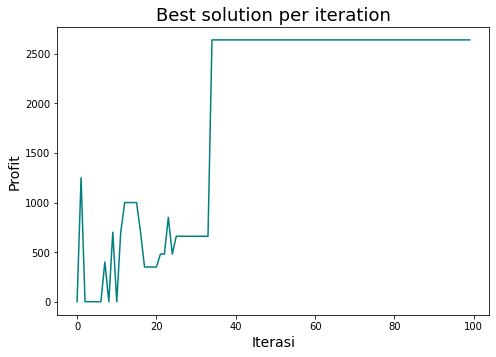

In [ ]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(hasils[1], color='teal')
plt.title('Best solution per iteration', size=18)
plt.ylabel('Profit', size=14)
plt.xlabel('Iterasi', size=14)
plt.show()

In [ ]:
print(hasils[1].max())
print(hasils[1].mean())

0    2750.0
dtype: float64
0    1905.9
dtype: float64


In [ ]:
#n_individu: 100, presentase: pembagian sama rata
dfparamss_ = pd.read_csv('ABC_params_kp.csv')
dfparamss_['n_individu'] = 100
dfparamss_['a'] = -4
dfparamss_['b'] = 4
dfparamss_['lim'] = 6000
dfparamss_['alpha'] = 20
dfparamss_['beta'] = 20
dfparamss_ = dfparamss_.drop('Unnamed: 0', axis='columns')
dfparamss_['max_generasi'] = 100
dfparamss_['presentase'] = '0.30|0.30|0.40'
dfparamss_

,n_individu,n_barang,a,b,alpha,beta,max_generasi,presentase,lim
0,100,18,-4,4,20,20,100,0.30|0.30|0.40,6000
1,100,18,-4,4,20,20,100,0.30|0.30|0.40,6000
2,100,18,-4,4,20,20,100,0.30|0.30|0.40,6000


In [ ]:
ress_ = run_BCO(dfparamss_,df)
hasils_ = ress_[2]
hasils_[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


,0
0,750.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
95,2000.0
96,2000.0
97,2000.0
98,2000.0


In [ ]:
ress_ = run_BCO(dfparamss_,df)
hasils_ = ress_[2]
hasils_[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


,Jenis Produk 1,Jenis Produk 2,Jenis Produk 3,Jenis Produk 4,Jenis Produk 5,Jenis Produk 6,Jenis Produk 7,Jenis Produk 8,Jenis Produk 9,Jenis Produk 10,Jenis Produk 11,Jenis Produk 12,Jenis Produk 13,Jenis Produk 14,Jenis Produk 15,Jenis Produk 16,Jenis Produk 17,Jenis Produk 18,Profit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,615.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,540.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
97,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
print(hasils_[1].max())
print(hasils_[1].mean())

0    2000.0
dtype: float64
0    1222.7
dtype: float64


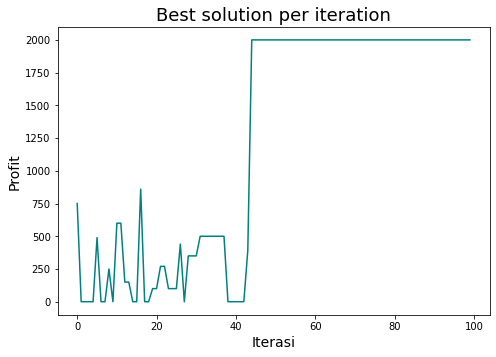

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(hasils_[1], color='teal')
plt.title('Best solution per iteration', size=18)
plt.ylabel('Profit', size=14)
plt.xlabel('Iterasi', size=14)
plt.show()

In [ ]:
#n_individu: 100, presentase onlooker lebih besar
dfparamss_1 = pd.read_csv('ABC_params_kp.csv')
dfparamss_1['n_individu'] = 100
dfparamss_1['a'] = -4
dfparamss_1['b'] = 4
dfparamss_1['lim'] = 6000
dfparamss_1['alpha'] = 20
dfparamss_1['beta'] = 20
dfparamss_1 = dfparamss_1.drop('Unnamed: 0', axis='columns')
dfparamss_1['max_generasi'] = 100
dfparamss_1['presentase'] = '0.25|0.25|0.50'
dfparamss_1

,n_individu,n_barang,a,b,alpha,beta,max_generasi,presentase,lim
0,100,18,-4,4,20,20,100,0.25|0.25|0.50,6000
1,100,18,-4,4,20,20,100,0.25|0.25|0.50,6000
2,100,18,-4,4,20,20,100,0.25|0.25|0.50,6000


In [ ]:
ress1 = run_BCO(dfparamss_1,df)
hasils1 = ress1[2]
hasils1[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


,0
0,0.0
1,980.0
2,0.0
3,0.0
4,0.0
...,...
95,910.0
96,910.0
97,910.0
98,910.0


In [ ]:
save_BCO(ress1[2])

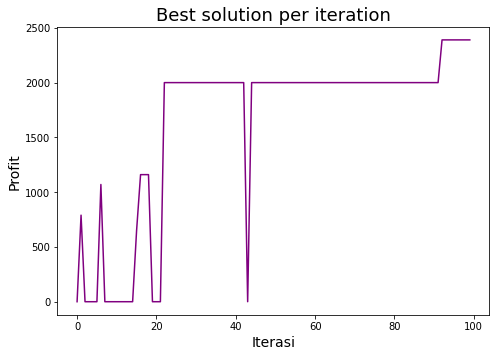

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(hasils1[1], color='purple')
plt.title('Best solution per iteration', size=18)
plt.ylabel('Profit', size=14)
plt.xlabel('Iterasi', size=14)
plt.show()

In [ ]:
#n_individu: 100, presentase employed lebih besar
dfparamss_2 = pd.read_csv('ABC_params_kp.csv')
dfparamss_2['n_individu'] = 100
dfparamss_2['a'] = -4
dfparamss_2['b'] = 4
dfparamss_2['lim'] = 6000
dfparamss_2['alpha'] = 20
dfparamss_2['beta'] = 20
dfparamss_2 = dfparamss_2.drop('Unnamed: 0', axis='columns')
dfparamss_2['max_generasi'] = 100
dfparamss_2['presentase'] = '0.50|0.25|0.25'
dfparamss_2

,n_individu,n_barang,a,b,alpha,beta,max_generasi,presentase,lim
0,100,18,-4,4,20,20,100,0.50|0.25|0.25,6000
1,100,18,-4,4,20,20,100,0.50|0.25|0.25,6000
2,100,18,-4,4,20,20,100,0.50|0.25|0.25,6000


In [ ]:
ress2 = run_BCO(dfparamss_2,df)
hasils2 = ress2[2]
hasils2[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


,0
0,0.0
1,0.0
2,0.0
3,3060.0
4,0.0
...,...
95,2350.0
96,2350.0
97,2350.0
98,2350.0


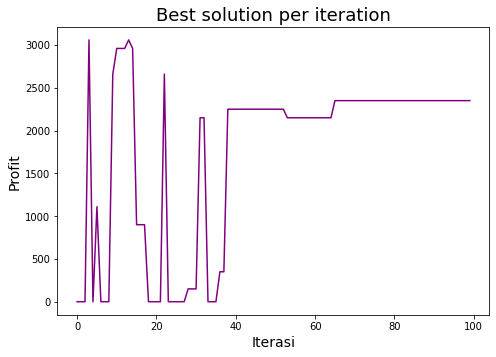

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(hasils2[1], color='purple')
plt.title('Best solution per iteration', size=18)
plt.ylabel('Profit', size=14)
plt.xlabel('Iterasi', size=14)
plt.show()

In [ ]:
#n_individu: 100, presentase scout lebih besar
dfparamss_3 = pd.read_csv('ABC_params_kp.csv')
dfparamss_3['n_individu'] = 100
dfparamss_3['a'] = -4
dfparamss_3['b'] = 4
dfparamss_3['lim'] = 6000
dfparamss_3['alpha'] = 20
dfparamss_3['beta'] = 20
dfparamss_3 = dfparamss_3.drop('Unnamed: 0', axis='columns')
dfparamss_3['max_generasi'] = 100
dfparamss_3['presentase'] = '0.25|0.50|0.25'
dfparamss_3

,n_individu,n_barang,a,b,alpha,beta,max_generasi,presentase,lim
0,100,18,-4,4,20,20,100,0.25|0.50|0.25,6000
1,100,18,-4,4,20,20,100,0.25|0.50|0.25,6000
2,100,18,-4,4,20,20,100,0.25|0.50|0.25,6000


In [ ]:
ress3 = run_BCO(dfparamss_3,df)
hasils3 = ress3[2]
hasils3[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


,0
0,2370.0
1,0.0
2,0.0
3,0.0
4,2760.0
...,...
95,3060.0
96,3060.0
97,3060.0
98,3060.0


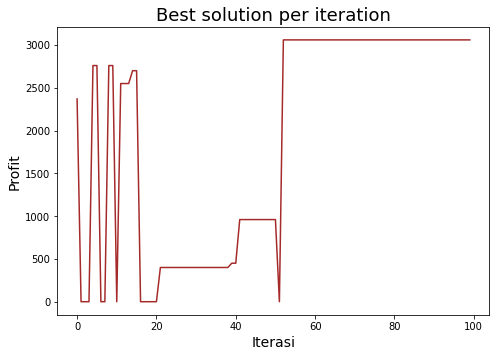

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(hasils3[1], color='brown')
plt.title('Best solution per iteration', size=18)
plt.ylabel('Profit', size=14)
plt.xlabel('Iterasi', size=14)
plt.show()